This example is available as a jupyter notebook [here](https://github.com/SimiPixel/x_xy_v2/blob/main/docs/notebooks/machine_learning.ipynb).

And on Google Colab [here](https://colab.research.google.com/github/SimiPixel/x_xy_v2/blob/main/docs/notebooks/machine_learning.ipynb)

Setup the environment if this is executed on Google Colab.

*Make sure to change the runtime type to `GPU`. To do this go to `Runtime` -> `Change runtime type` -> `GPU`*

Otherwise, rendering won't work in Google Colab.

In [1]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.system("pip install --quiet 'x_xy[all_muj] @ git+https://github.com/SimiPixel/x_xy_v2'")
    os.system("pip install --quiet mediapy")

import x_xy
# automatically detects colab or not
x_xy.utils.setup_colab_env()

In [16]:
from x_xy.subpkgs import ml, exp, sys_composer, sim2real
import mediapy
import jax.numpy as jnp
import tree_utils

In [3]:
def load_data_and_prediction(motion, sys, params, debug: bool = False):
    exp_data = exp.load_data("S_04", motion)
    xml_str = exp.load_xml_str("S_04")
    xs = sim2real.xs_from_raw(sys, exp.link_name_pos_rot_data(exp_data, xml_str), qinv=True)

    # slightly decrease `transform1.pos.x` by a little; purely for better optics
    translations, rotations = sim2real.unzip_xs(sys, xs)
    seg_mask = jnp.array([sys.name_to_idx(name) for name in sys.link_names[1:] if name[:3] != "imu"])
    imu_mask = jnp.array([sys.name_to_idx(name) for name in sys.link_names[1:] if name[:3] == "imu"])
    translations = translations.replace(pos=translations.pos.at[:, seg_mask, 0].set(translations.pos[:, seg_mask, 0] - 0.03))
    translations = translations.replace(pos=translations.pos.at[:, imu_mask, 0].set(translations.pos[:, imu_mask, 0] + 0.03))
    xs_translated = sim2real.zip_xs(sys, translations, rotations)

    X = {seg: {} for seg in ["seg2", "seg3", "seg4"]}
    for seg in X:
        imu_data = exp_data[seg]["imu_rigid"]
        imu_data.pop("mag")
        if seg == "seg3":
            imu_data = tree_utils.tree_zeros_like(imu_data)
        X[seg].update(imu_data)

    sys_noimu, _ = sys_composer.make_sys_noimu(sys)
    filter = ml.InitApplyFnFilter(init_apply_fn_factory=lambda sys: ml.make_rnno(sys, debug=debug), params=params)
    yhat = filter.predict(X, sys_noimu)
    return xs_translated, yhat


In [4]:
params = ml.load(pretrained="rr_rr_unknown")
motion = "thomas_fast"
sys = exp.load_sys("S_04", morph_yaml_key="seg2", delete_after_morph=["seg5", "imu3"])

xs, yhat = load_data_and_prediction(motion, sys, params)
frames = x_xy.render_prediction(sys, xs, yhat, stepframe=4, width=640, height=480, camera="c", 
                         add_cameras={-1: '<camera name="c" mode="targetbody" target="3" pos=".5 -.5 1.25"/>',})

Rendering frames..: 100%|██████████| 1150/1150 [00:06<00:00, 184.83it/s]


In [5]:
mediapy.show_video(frames, fps=25.0)

## How to get all latent states of the RNNo? The `debug` flag

In [6]:
_, rnno_output = load_data_and_prediction(motion, sys, params, debug=True)

In [7]:
rnno_output.keys()

dict_keys(['debug', 'outputs'])

these are the regular outputs; i.e. if `debug=False`

In [8]:
rnno_output["outputs"].keys()

dict_keys(['seg3', 'seg4'])

In [9]:
rnno_output["outputs"]["seg3"].shape

(4600, 4)

these are the debug outputs

In [10]:
rnno_output["debug"].keys()

dict_keys(['mailbox', 'msg', 'state'])

In [11]:
# shape is (n_timesteps, n_links, n_stacked_rnn_cells, hidden_state_dim)
# the links are three without the IMUs
# we use only one GRU cell, so it's 1
# the hidden state dimension of that cell is 400
rnno_output["debug"]["state"].shape

(4600, 3, 1, 400)

In [15]:
# shape is (n_timesteps, n_links, message_dim) 
rnno_output["debug"]["msg"].shape

(4600, 3, 200)

In [13]:
# shape is (n_timesteps, n_links, message_dim) 
rnno_output["debug"]["mailbox"].shape

(4600, 3, 200)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

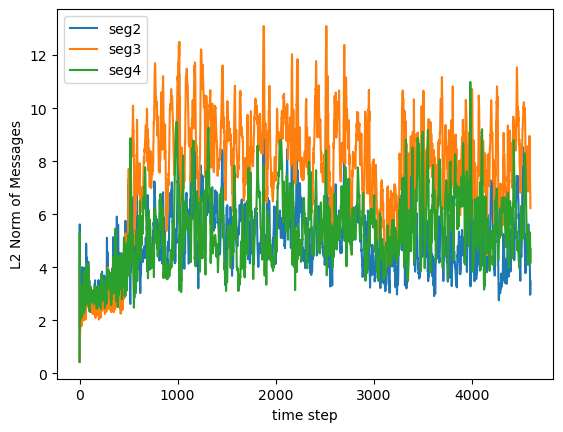

In [22]:
plt.plot(np.linalg.norm(rnno_output["debug"]["msg"], axis=-1), label=sys.findall_segments())
plt.legend()
plt.ylabel("L2 Norm of Messages")
plt.xlabel("time step")
plt.show()
